In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import h5py
from sklearn.preprocessing import MinMaxScaler
import warnings
import os
import tqdm
warnings.filterwarnings('ignore')

2023-10-10 14:18:26.976431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 14:18:29.103781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("../data/merge.csv")
dtfl = h5py.File("../data/merge.hdf5", 'r')

In [3]:
df.head()

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-21 05:55:00,noise,109C.TA_201510210555_NO
1,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06 14:50:00,noise,109C.TA_201511061450_NO
2,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-07 02:20:00,noise,109C.TA_201511070220_NO
3,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-14 05:15:00,noise,109C.TA_201511140515_NO
4,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-25 18:50:00,noise,109C.TA_201512251850_NO


In [4]:
df = df[df["trace_category"] == "earthquake_local"]

In [54]:
df

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
235426,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.50,17.080000,...,NaN,NaN,0.9200,102.09,159.3,[56.79999924 55.40000153 47.40000153],[[2896.]],2006-07-23 15:59:00.960000,earthquake_local,109C.TA_20060723155859_EV
235427,TA,109C,BH,32.8889,-117.1051,150.0,600.0,manual,0.50,16.879999,...,NaN,NaN,0.9100,101.34,281.7,[65. 65.5 61.40000153],[[5508.]],2006-11-03 15:56:53.610000,earthquake_local,109C.TA_20061103155652_EV
235428,TA,109C,BH,32.8889,-117.1051,150.0,500.0,manual,0.50,17.260000,...,NaN,NaN,0.9200,101.87,280.5,[37.20000076 42. 38.59999847],[[3114.]],2006-11-03 16:12:24.700000,earthquake_local,109C.TA_20061103161223_EV
235429,TA,109C,BH,32.8889,-117.1051,150.0,900.0,manual,0.50,17.280001,...,NaN,NaN,0.9300,103.26,281.6,[54.09999847 54.90000153 45.5 ],[[3152.]],2006-11-14 13:32:22.540000,earthquake_local,109C.TA_20061114133221_EV
235430,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.50,18.139999,...,NaN,NaN,0.9200,102.48,4.7,[58.20000076 56.20000076 53.79999924],[[3134.]],2006-11-27 10:46:41.060000,earthquake_local,109C.TA_20061127104640_EV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265652,WY,YHL,HH,44.8509,-111.1830,2691.0,400.0,manual,0.68,4.210000,...,NaN,NaN,0.1253,13.93,124.9,[34.40000153 33. 36.70000076],[[1239.]],2017-06-21 09:40:43.810000,earthquake_local,YHL.WY_20170621094042_EV
1265653,WY,YHL,HH,44.8509,-111.1830,2691.0,600.0,manual,0.65,4.840000,...,NaN,NaN,0.1553,17.26,121.7,[44.20000076 43.79999924 41.40000153],[[1551.]],2017-06-21 12:21:05.390000,earthquake_local,YHL.WY_20170621122104_EV
1265654,WY,YHL,HH,44.8509,-111.1830,2691.0,500.0,manual,0.65,4.820000,...,NaN,NaN,0.1534,17.05,121.5,[47.5 39.90000153 42.70000076],[[1443.]],2017-06-21 12:23:40.200000,earthquake_local,YHL.WY_20170621122339_EV
1265655,WY,YHL,HH,44.8509,-111.1830,2691.0,500.0,manual,0.59,4.260000,...,NaN,NaN,0.1267,14.08,126.6,[24.70000076 21.89999962 21. ],[[1322.]],2017-06-21 13:34:40.330000,earthquake_local,YHL.WY_20170621133439_EV


In [55]:
data = dtfl.get("data/" + "109C.TA_20060723155859_EV")
data = np.array(data)

In [60]:
def get_spectrogram(waveform):
    # waveform shape: (6000, 3) always
    results = [] 
    for i in range(3):
        stft = tf.signal.stft(waveform[:,i], frame_length=128, frame_step=76, fft_length=152)
        results.append(stft)
    spectogram = tf.stack(results, axis=-1)
    return spectogram
spec = get_spectrogram(data)
spec.shape

TensorShape([92, 65, 3])

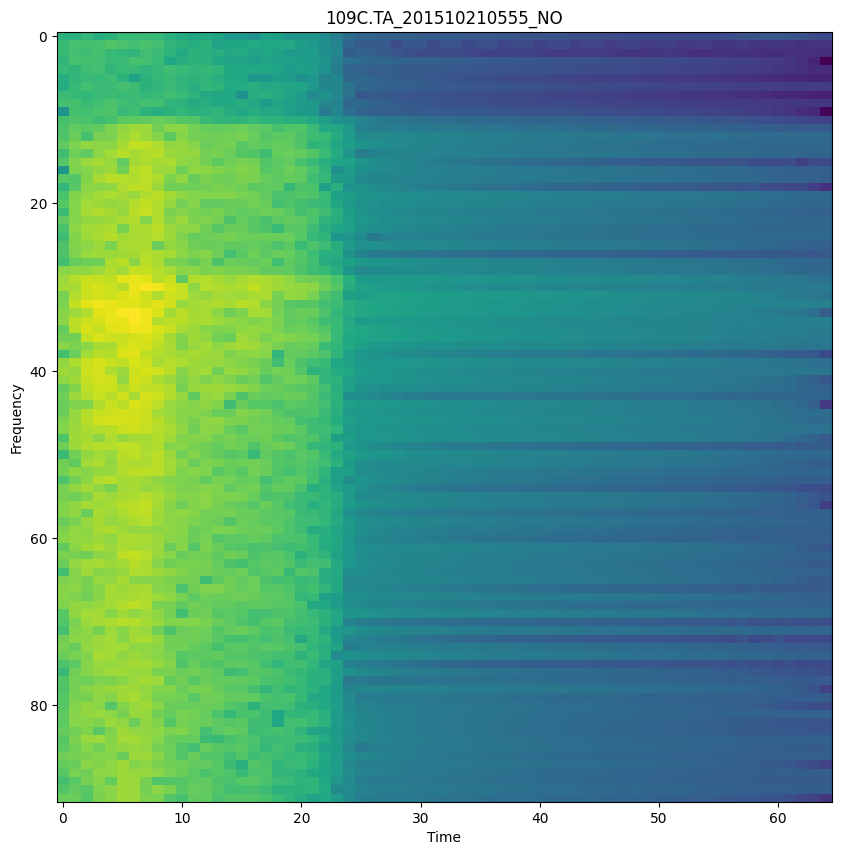

In [61]:
# plot spec
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(tf.math.log(np.abs(spec[:,:,0])), aspect='auto')
ax.set_title("109C.TA_201510210555_NO")
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
plt.show()

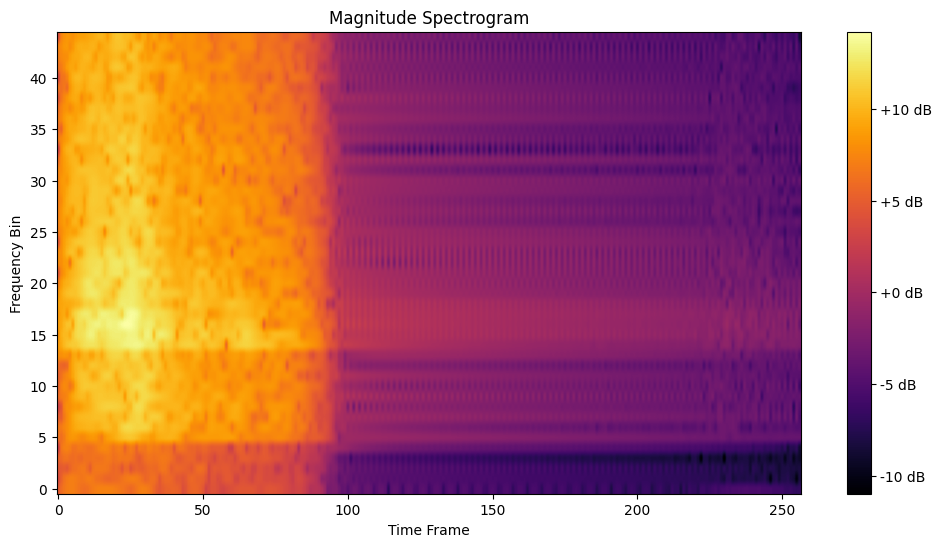

In [64]:
import tensorflow as tf

# Sample signal with 6000 samples

# Define STFT parameters
frame_length = 256  # Window size
frame_step = 128    # Hop size
fft_length = 512    # FFT size

# Apply STFT
stft = tf.signal.stft(data[:,0], frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

# Compute the magnitude of the STFT
magnitude = tf.abs(stft)

# Visualize the magnitude spectrogram (you can use matplotlib for visualization)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(tf.math.log(magnitude).numpy(), cmap='inferno', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Magnitude Spectrogram')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.show()


In [65]:
magnitude.shape

TensorShape([45, 257])

In [6]:
# get all filenames from ../data/specs
specs_done = os.listdir("../data/specs")

In [7]:
specs_done = [spec[:-4] for spec in specs_done]

In [8]:
all_specs = df["trace_name"].unique()

In [9]:
specs_filtered = list(set(all_specs) - set(specs_done))

In [10]:
len(all_specs), len(specs_done), len(specs_filtered)

(1030231, 803523, 226708)

In [11]:
for ev in tqdm.tqdm(specs_filtered):
    data = dtfl.get("data/" + ev)
    data = np.array(data)
    spec = get_spectrogram(data)
    # save the spectrogram
    np.save("../data/specs/" + ev + ".npy", spec.numpy())

  0%|          | 0/226708 [00:00<?, ?it/s]

2023-10-07 04:29:32.224570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 04:29:32.295296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 04:29:32.295388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 04:29:32.299917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 04:29:32.300016: I tensorflow/compile